In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
from pprint import pprint

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 获取网络数据并进行预处理

In [2]:
# 获取数据
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [3]:
# 数据划分
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, 
                                                            housing.target,
                                                            random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, 
                                                      y_train_all, 
                                                      random_state = 2)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

## 2. 生成CSV文件

In [5]:
# 构建目录
output_dir = "generate_csv"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
def save_to_csv(output_dir, data, name_prefix, header=None, n_parts=10):
    path_format = os.path.join(output_dir, "{}_{:02d}.csv")
    filenames = []
    for file_idx, row_indices in enumerate(np.array_split(np.arange(len(data)), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header + "\n")
            for row_index in row_indices:
                f.write(",".join([repr(col) for col in data[row_index]]))
                f.write("\n")
        filenames.append(part_csv)
        
# 合并数据 x 和 y
train_data = np.c_[x_train_scaled, y_train]  # np.c_默认从第二维度拼接
valid_data = np.c_[x_valid_scaled, y_valid]
test_data = np.c_[x_test_scaled, y_test]

header_cols = housing.feature_names + ["MidianHouseValue"]
header_str = ",".join(header_cols)

# 写入数据
train_filenames = save_to_csv(output_dir, train_data, "train", header_str, n_parts=20)
valid_filenames = save_to_csv(output_dir, valid_data, "valid", header_str, n_parts=10)
test_filenames = save_to_csv(output_dir, test_data, "test", header_str, n_parts=10)

## 3. 读取多个csv文件，并生成dataset类型的数据集

In [6]:
def names(directory):
    if not os.path.exists(directory):
        raise IOError
    file_names = os.listdir(directory)
    train_file_names = []
    valid_file_names = []
    test_file_names = []
    for name in file_names:
        if name.startswith("train"):
            train_file_names.append("generate_csv/" + name)
        elif name.startswith("valid"):
            valid_file_names.append("generate_csv/" + name)
        else:
            test_file_names.append("generate_csv/" + name)
    return train_file_names, valid_file_names, test_file_names

train_file_names, valid_file_names, test_file_names= names("generate_csv")

In [7]:
print("train_file_names:")
pprint(train_file_names[:3])
print("valid_file_names:")
pprint(valid_file_names[:3])
print("test_file_names:")
pprint(test_file_names[:3])

train_file_names:
['generate_csv/train_00.csv',
 'generate_csv/train_01.csv',
 'generate_csv/train_02.csv']
valid_file_names:
['generate_csv/valid_00.csv',
 'generate_csv/valid_01.csv',
 'generate_csv/valid_02.csv']
test_file_names:
['generate_csv/test_00.csv',
 'generate_csv/test_01.csv',
 'generate_csv/test_02.csv']


### 3.1 filename -> dataset

In [8]:
filename_dataset = tf.data.Dataset.list_files(train_file_names)
for filename in filename_dataset.take(4):    # .take()提取的行数
    print(filename)

tf.Tensor(b'generate_csv\\train_16.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv\\train_08.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv\\train_14.csv', shape=(), dtype=string)
tf.Tensor(b'generate_csv\\train_03.csv', shape=(), dtype=string)


### 3.2 read file -> dataset -> datasets ->merge

##### tf.data.TextLineDataset()

In [9]:
n_readers = 5
dataset = filename_dataset.interleave(
            lambda filename: tf.data.TextLineDataset(filename).skip(1), 
            cycle_length = n_readers)

for line in dataset.take(5):   
    print(line.numpy())

b'0.6216133377416374,0.34877507508105626,0.09784787148671302,-0.15320100586458107,-0.1957854000052381,-0.04840063829783664,0.7970525684974694,-1.2102367831190115,3.116'
b'0.9636774311241296,0.34877507508105626,0.6092477207855667,-0.061660535672652776,0.0939735391385625,0.0017833539192596522,-1.3976734443198464,1.2643108301515529,2.346'
b'0.03283365680763377,0.5070953543096866,0.0017446242040271443,-0.22257158459772564,-0.703528128229696,0.013969876695695074,-0.7453132706586459,0.83201034349585,1.875'
b'-1.0180727009381736,0.7445757731526319,-0.39238606001141596,-0.15863817055901175,0.000931677945599006,0.12245966360031377,0.40563646430075245,0.11150953240302118,0.514'
b'0.5127650992010306,-0.9177871587479858,0.2063180216522211,0.05494679041476598,3.5843725033203073,-0.030173606626313083,0.825010861654379,-1.4040266564474293,3.543'


### 3.3 parse csv

In [10]:
# tf.io.decode_csv使用
sample_str = "101, 102, 103, 104, 105"
# 定义每列数据类型，可以有以下几种灵活的定义方式
record_defaults = [tf.constant(0, dtype=tf.int32),
                   0,                 
                   np.nan,
                   "hello",
                   tf.constant([])]
parsed_fields = tf.io.decode_csv(sample_str, record_defaults)
pprint(parsed_fields)

[<tf.Tensor: id=76, shape=(), dtype=int32, numpy=101>,
 <tf.Tensor: id=77, shape=(), dtype=int32, numpy=102>,
 <tf.Tensor: id=78, shape=(), dtype=float32, numpy=103.0>,
 <tf.Tensor: id=79, shape=(), dtype=string, numpy=b' 104'>,
 <tf.Tensor: id=80, shape=(), dtype=float32, numpy=105.0>]


In [11]:
# tf.io.decode_csv 可能遇到的几种异常情况
# 有空元素
parsed_fields = tf.io.decode_csv(",2,,3,6", record_defaults)
pprint(parsed_fields)
print("----------")

# 全为空
try:
    parsed_fields = tf.io.decode_csv(",,,,", record_defaults)
    pprint(parsed_fields)
except tf.errors.InvalidArgumentError as ex:
    print(ex)
print("----------")

# 元素列数多于类型定义列表
try:
    parsed_fields = tf.io.decode_csv("1,2,3,4,5,6,7",record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

[<tf.Tensor: id=85, shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: id=86, shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: id=87, shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: id=88, shape=(), dtype=string, numpy=b'3'>,
 <tf.Tensor: id=89, shape=(), dtype=float32, numpy=6.0>]
----------
Field 4 is required but missing in record 0! [Op:DecodeCSV]
----------
Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


In [12]:
def parse_csv_line(line, n_fields=9):
    defs = [tf.constant(np.nan)] * n_fields
    parsed_fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(parsed_fields[0:-1])
    y = tf.stack(parsed_fields[-1:])
    return x, y
    
parse_csv_line(b'-0.3029478917855559,0.26399901350276267,-0.23841843164342102,0.07020060708730767,1.8750131493689683,0.015173487553336078,-0.7256808232726312,0.8334536233193711,2.044',
              n_fields=9)

(<tf.Tensor: id=109, shape=(8,), dtype=float32, numpy=
 array([-0.30294788,  0.26399902, -0.23841843,  0.07020061,  1.8750131 ,
         0.01517349, -0.7256808 ,  0.8334536 ], dtype=float32)>,
 <tf.Tensor: id=110, shape=(1,), dtype=float32, numpy=array([2.044], dtype=float32)>)

### 3.4 三个步骤合并使用

In [13]:
# 1. filename -> dataset
# 2. read file -> dataset -> datasets ->merge
# 3. parse csv
def csv_reader_dataset(filenames, n_readers=5, batch_size=32, 
                       n_parse_threads=5, shuffle_buffer_size=10000):
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()    # 未指定数字则重复无限次
    dataset = dataset.interleave(
                lambda filename: tf.data.TextLineDataset(filename).skip(1),
                cycle_length=n_readers)
    dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse_csv_line,
                          num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset

# 取个小的batch_size以验证函数正确性和展示结果
train_set = csv_reader_dataset(train_file_names, batch_size=4)
for x_batch, y_batch in train_set.take(2):
    print("x:")
    pprint(x_batch)
    print("y:")
    pprint(y_batch)

x:
<tf.Tensor: id=194, shape=(4, 8), dtype=float32, numpy=
array([[-1.01807272e+00,  7.44575799e-01, -3.92386049e-01,
        -1.58638164e-01,  9.31677932e-04,  1.22459665e-01,
         4.05636460e-01,  1.11509532e-01],
       [-1.60098635e-02,  3.48775089e-01, -1.45162001e-01,
        -1.68492213e-01,  6.92985892e-01,  3.41474377e-02,
        -8.52486730e-01,  8.46917272e-01],
       [-4.36255485e-01, -1.70938861e+00, -9.51952562e-02,
        -6.60906360e-02,  7.09822059e-01, -5.64874746e-02,
         2.29282117e+00, -1.35930586e+00],
       [-7.64394641e-01,  1.45701706e+00, -2.03422800e-01,
        -1.55476853e-01, -2.02874303e-01,  1.03040993e-01,
        -7.49972999e-01,  7.02817082e-01]], dtype=float32)>
y:
<tf.Tensor: id=195, shape=(4, 1), dtype=float32, numpy=
array([[0.514],
       [2.118],
       [1.017],
       [1.229]], dtype=float32)>
x:
<tf.Tensor: id=196, shape=(4, 8), dtype=float32, numpy=
array([[-1.4568672 ,  1.0612164 , -0.673559  , -0.14353533, -0.4633915 ,
        

In [14]:
batch_size = 32
train_set = csv_reader_dataset(train_file_names, batch_size=batch_size)
valid_set = csv_reader_dataset(valid_file_names, batch_size=batch_size)
test_set = csv_reader_dataset(test_file_names, batch_size=batch_size)

## 4. 定义并训练模型

In [15]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_dim=8),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="sgd")

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = model.fit(train_set, 
          epochs=100,
          validation_data=valid_set,
          steps_per_epoch = 11610 // batch_size,
          validation_steps = 3870 // batch_size,             
          callbacks = callbacks)

Train for 362 steps, validate for 120 steps
Epoch 1/100
362/362 [==============================] - 1s 3ms/step - loss: 1.1193 - val_loss: 0.6039
Epoch 2/100
362/362 [==============================] - 1s 1ms/step - loss: 0.5383 - val_loss: 0.5159
Epoch 3/100
362/362 [==============================] - 0s 1ms/step - loss: 0.4836 - val_loss: 0.4690
Epoch 4/100
362/362 [==============================] - 1s 1ms/step - loss: 0.4628 - val_loss: 0.4534
Epoch 5/100
362/362 [==============================] - 1s 1ms/step - loss: 0.4474 - val_loss: 0.4433
Epoch 6/100
362/362 [==============================] - 1s 1ms/step - loss: 0.4367 - val_loss: 0.4356
Epoch 7/100
362/362 [==============================] - 0s 1ms/step - loss: 0.4380 - val_loss: 0.4265
Epoch 8/100
362/362 [==============================] - 0s 1ms/step - loss: 0.4236 - val_loss: 0.4230
Epoch 9/100
362/362 [==============================] - 0s 1ms/step - loss: 0.4201 - val_loss: 0.4173
Epoch 10/100
362/362 [=========================

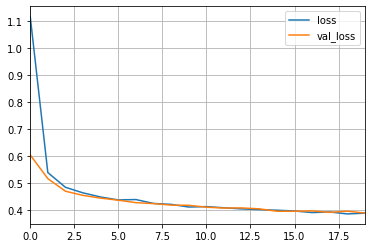

In [16]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(6,4), grid=True)
    plt.show()

plot_learning_curves(history)

In [17]:
model.evaluate(test_set, steps = 5160 // batch_size)   # 因为dataset.repeat()在不停的产生batch，所以需要指定步数

161/161 [==============================] - 0s 857us/step - loss: 0.4121


0.4121402612198954